In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [ ]:
#Load and prepare the dataset

(train_image,train_label),(_,_)=tf.keras.datasets.fashion_mnist.load_data()

train_image=train_image.reshape(train_image.shape[0],28,28,1).astype('float32')
train_image=(train_image-128)/128 #normalize the image

BUFFER_SIZE=60000
BATCH_SIZE=256

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#Batch and Shuffle the data

train_set=tf.data.Dataset.from_tensor_slices(train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

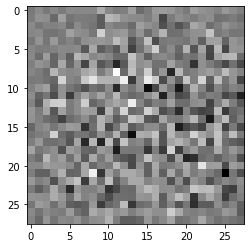

In [ ]:
# Define the architectures for generator and discriminator


#Architecture for Generator

def generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(300,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256)
# Conv2DTranspose are used to upsample for generating
#an image from a seed which is random noise

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation="tanh"))
    assert model.output_shape==(None,28,28,1)
    model.add(layers.BatchNormalization())
    
    
    return model

generator=generator_model()


noise=tf.random.normal([1,300])
generated_img=generator(noise,training=False)
plt.imshow(generated_img[0,:,:,0],cmap="gray")
    

In [ ]:
model=generator_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12544)             3763200   
_________________________________________________________________
batch_normalization_20 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 7, 7, 128)        

In [ ]:
# Architecture for Discriminator model

def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator=discriminator_model()
decision_output=discriminator(generated_img)  #D(G(x))
print(decision_output)
model=discriminator_model()
model.summary()

tf.Tensor([[-0.00123214]], shape=(1, 1), dtype=float32)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_______________________________________________________________

In [ ]:
#compute CrossEntropyLoss

cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:

# Define discriminator loss

def discriminator_loss(true_output,fake_output):
    true_loss= cross_entropy(tf.ones_like(true_output),true_output)  #true output  denotes as 1 in binary classification
    fake_loss= cross_entropy(tf.zeros_like(fake_output),fake_output) #fake output will be zero
    tot_loss=true_loss+fake_loss
    return tot_loss
    

In [ ]:
# Define Generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
#generator will create a fake output similar as the true output to fool discriminator
#So, generator will create one as fake output

In [ ]:
# Defining separate optimizers for generator and discriminator

gen_optimizer=tf.keras.optimizers.Adam(1e-4)
dis_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoints_dir="D:/deep learning research paper/GAN/training_chpk"

checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer, dis_optimizer=dis_optimizer, generator=generator, discriminator=discriminator)

In [ ]:
EPOCHS=200

noise_dim=300
num_ex_to_gen=16

seed=tf.random.normal([num_ex_to_gen,noise_dim])

In [ ]:
@tf.function

def train_step(images):
    
    noise=tf.random.normal([BATCH_SIZE,noise_dim])
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 12 EPOCHS
        if (epoch + 1) % 12 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generator after final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

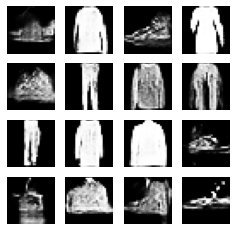

CPU times: user 11min 35s, sys: 1min 46s, total: 13min 21s
Wall time: 47min 56s


In [ ]:

%%time
train(train_set, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))